In [1]:
#!nvidia-smi

In [22]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchsummary import summary

from DatasetLogReturn import StockDatasetLogReturn
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt

In [15]:
configs = {
    "batch_size" : 128,
    "max_file_count" : 2179,
    "train_file" : 12,
    "validation_file" : 7,
    "test_file" : 7,
    "input_size" : 5,
    "output_size" : 1,
    "init_learning_rate" : 1e-2,
    "scheduler_factor": 0.2,
    "scheduler_patience": 2,
    "scheduler_min_lr": 1e-4,
    "epoch" : 150,
    "model_name" : "LSTM1",
}

configs["file_count"] = configs["train_file"] + configs["validation_file"] + configs["test_file"]
configs["model_folder"] = f"./models/{configs["model_name"]}/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
tickers = list(map(str.strip,open("tickers.txt","r").readlines()))
filenames = ["./data/" + x + ".csv" for x in tickers]
rd.shuffle(filenames)
filenames = filenames[:configs["file_count"]]

train_files, test_files = train_test_split(filenames,test_size=configs["test_file"]/configs["file_count"])
train_files, val_files = train_test_split(train_files,test_size=configs["validation_file"]/(configs["train_file"] + configs["validation_file"]))

train_dataset = StockDatasetLogReturn(train_files, configs["input_size"], configs["output_size"])
train_dataset.Preprocess()
train_loader = DataLoader(train_dataset,batch_size=configs["batch_size"],shuffle=True)

val_dataset = StockDatasetLogReturn(val_files,configs["input_size"],configs["output_size"])
val_dataset.Preprocess()
val_loader = DataLoader(val_dataset,batch_size=configs["batch_size"],shuffle=True)

test_dataset = StockDatasetLogReturn(test_files,configs["input_size"],configs["output_size"])
test_dataset.Preprocess()
test_loader = DataLoader(test_dataset,batch_size=configs["batch_size"],shuffle=True)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/70031 [00:00<?, ?it/s]

d:\Programming\Pattern_Reg_Final\DatasetLogReturn.py:48: RuntimeWarning: divide by zero encountered in log
  c = np.log(b)
d:\Programming\Pattern_Reg_Final\DatasetLogReturn.py:48: RuntimeWarning: divide by zero encountered in log
  c = np.log(b)
d:\Programming\Pattern_Reg_Final\DatasetLogReturn.py:48: RuntimeWarning: divide by zero encountered in log
  c = np.log(b)
d:\Programming\Pattern_Reg_Final\DatasetLogReturn.py:48: RuntimeWarning: divide by zero encountered in log
  c = np.log(b)
d:\Programming\Pattern_Reg_Final\DatasetLogReturn.py:48: RuntimeWarning: divide by zero encountered in log
  c = np.log(b)
d:\Programming\Pattern_Reg_Final\DatasetLogReturn.py:48: RuntimeWarning: divide by zero encountered in log
  c = np.log(b)
d:\Programming\Pattern_Reg_Final\DatasetLogReturn.py:48: RuntimeWarning: divide by zero encountered in log
  c = np.log(b)
d:\Programming\Pattern_Reg_Final\DatasetLogReturn.py:48: RuntimeWarning: divide by zero encountered in log
  c = np.log(b)
d:\Programming\P

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/56148 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/32613 [00:00<?, ?it/s]

In [4]:
torch.set_default_dtype(torch.float32)
class StockLSTM(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.hidden_size = 256
        self.batch_size = configs["batch_size"]
        self.h0 = torch.zeros((4,self.batch_size,self.hidden_size)).to(device)
        self.c0 = torch.zeros((4,self.batch_size,self.hidden_size)).to(device)
        self.layer1 = nn.LSTM(1,self.hidden_size,4,dropout=0.2,batch_first=True)
        self.layer2 = nn.Sequential(
            nn.Linear(self.hidden_size,64),
            nn.ReLU()
        )
        self.layer3 = nn.Linear(64,1)

    def forward(self, input) :
        h1,(hn,cn) = self.layer1(input,(self.h0,self.c0))
        h2 = self.layer2(h1[:,-1,:])
        output = self.layer3(h2)
        return output


In [5]:
model = StockLSTM()
model = model.to(device)

summary(model,input_size=(configs["batch_size"],configs["input_size"],1))

Layer (type:depth-idx)                   Param #
├─LSTM: 1-1                              1,844,224
├─Sequential: 1-2                        --
|    └─Linear: 2-1                       16,448
|    └─ReLU: 2-2                         --
├─Linear: 1-3                            65
Total params: 1,860,737
Trainable params: 1,860,737
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─LSTM: 1-1                              1,844,224
├─Sequential: 1-2                        --
|    └─Linear: 2-1                       16,448
|    └─ReLU: 2-2                         --
├─Linear: 1-3                            65
Total params: 1,860,737
Trainable params: 1,860,737
Non-trainable params: 0

In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr = configs["init_learning_rate"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=configs['scheduler_factor'],
    patience=configs['scheduler_patience'],
    min_lr=configs['scheduler_min_lr']
)
loss_fn = torch.nn.L1Loss()

In [16]:
train_losses = []
val_losses = []
model_folder = configs["model_folder"]
best_loss = 1000000

for epoch in tqdm(range(configs["epoch"])) :

    model.train()

    cur_train_loss = []
    for input,target in tqdm(train_loader) :

        close_price_input = input[:,4,:,None]
        close_price_target = target[:,4,:]
        close_price_input = close_price_input.to(device)
        close_price_target = close_price_target.to(device)

        if(close_price_input.shape[0] != configs["batch_size"]) :
            continue

        optimizer.zero_grad()

        output = model(close_price_input)

        loss = loss_fn(output,close_price_target)

        loss.backward()

        optimizer.step()

        train_losses.append(loss.to(torch.device("cpu")).item())
        cur_train_loss.append(loss.to(torch.device("cpu")).item())

    avarage_train_loss = np.mean(np.array(cur_train_loss))

    model.eval()

    with torch.no_grad() :
        cur_val_loss = []
        for input,target in tqdm(val_loader) :

            close_price_input = input[:,4,:,None]
            close_price_target = target[:,4,:]
            close_price_input = close_price_input.to(device)
            close_price_target = close_price_target.to(device)

            if(close_price_input.shape[0] != configs["batch_size"]) :
                continue

            output = model(close_price_input)

            loss = loss_fn(output,close_price_target)

            val_losses.append(loss.to(torch.device("cpu")).item())
            cur_val_loss.append(loss.to(torch.device("cpu")).item())

        avarage_val_loss = np.mean(np.array(cur_val_loss))

        scheduler.step(avarage_val_loss)
        
        if(best_loss > avarage_val_loss) :

            state = {
                'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avarage_train_loss,
                'val_loss': avarage_val_loss,
                'best_val_loss': best_loss,
            }

            torch.save(state, model_folder + "LSTM.pth.tar")

    print("train loss : ",avarage_train_loss)
    print("val loss : ",avarage_val_loss)


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014903966817575791
val loss :  0.017614810859367728


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014906381805115797
val loss :  0.017609430034751218


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014910071614918587
val loss :  0.017620457232117515


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014910575528535482
val loss :  0.017619111247734937


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.01490858325588311
val loss :  0.017619371990413836


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.01489588567370743
val loss :  0.01761373153305081


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897303749386637
val loss :  0.01760754859517222


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014898264550789509
val loss :  0.017612449240075535


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014898332663329907
val loss :  0.01761287347451873


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014896972865969542
val loss :  0.01761786818087577


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.01489744369975773
val loss :  0.0176219034017187


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014895093080739217
val loss :  0.01761796584429398


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897598602368039
val loss :  0.01761977598879095


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014896234233524834
val loss :  0.017614126662600395


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014898014443856706
val loss :  0.017610555389241132


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014896587957330116
val loss :  0.017611291646515124


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014896785624161826
val loss :  0.017614024735936155


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014896295930665852
val loss :  0.017617765495119845


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014896754529565518
val loss :  0.017626282276339045


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897588063269799
val loss :  0.017612881537475814


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014898127682125655
val loss :  0.01761251468568632


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014896381779197583
val loss :  0.017619269134553327


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897442450048828
val loss :  0.01762834034826113


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014896492913052086
val loss :  0.01762520001997074


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.01489824896177764
val loss :  0.01761546052065274


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.0148971796025551
val loss :  0.01761161390326271


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014898906661098792
val loss :  0.017622051226851194


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.01489501303467062
val loss :  0.017613500788314567


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897586777806282
val loss :  0.017620424682606165


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897557552665527
val loss :  0.017622879993374627


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014894212873642362
val loss :  0.0176112821334165


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014895684070462937
val loss :  0.01761994660155822


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014893035874301925
val loss :  0.01761624042676192


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014895106022207023
val loss :  0.017618169614696474


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.01489869702838947
val loss :  0.017614024576463112


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014898022912592512
val loss :  0.01760474503567638


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.01489674899100549
val loss :  0.017615678469271964


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014894266427244304
val loss :  0.017635703701355823


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.01489839273278467
val loss :  0.017611983149274164


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897647593000144
val loss :  0.017609148479776977


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897569951003714
val loss :  0.017621257578418273


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014896890575873241
val loss :  0.017616485781355263


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014896334094460202
val loss :  0.017608385758482975


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014896579258743218
val loss :  0.01763016118170464


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014895240893720274
val loss :  0.017621382392653727


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014896345392918347
val loss :  0.017610654838757428


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897574868114492
val loss :  0.017608394846320152


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.01489906733041762
val loss :  0.01761778613093169


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897248602150455
val loss :  0.01761682522504433


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014896347400284555
val loss :  0.017611658340957882


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897637317805012
val loss :  0.017619895472374136


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897645165091568
val loss :  0.017612908518188485


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014896917129633522
val loss :  0.01761326051984816


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014898058163237093
val loss :  0.017613088316603066


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.01489594653487151
val loss :  0.017610813484667507


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897148455178172
val loss :  0.01762116793968362


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014898654902643325
val loss :  0.01761551428858412


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014898344773928578
val loss :  0.017617222047134486


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014898148016285634
val loss :  0.017618868587172876


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014896717171101291
val loss :  0.017622254697444367


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897730426226063
val loss :  0.017613085165415723


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897739460225297
val loss :  0.017609075404975784


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014896995381160998
val loss :  0.017614230596498675


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014896256236233484
val loss :  0.017616878372093994


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.01489891356514457
val loss :  0.01761611987151988


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014898734243835239
val loss :  0.01762020479266842


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.01489555298893881
val loss :  0.01761866178890886


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897510068835027
val loss :  0.01761659688303528


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897788679005895
val loss :  0.01761540652095387


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.01489789512049291
val loss :  0.017609238299247744


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014896900585462667
val loss :  0.017608689388779065


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014898946074602046
val loss :  0.017619648238125184


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897843536799961
val loss :  0.017618526232569185


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014896199875043014
val loss :  0.017610903795315252


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014896638985975243
val loss :  0.017616443650703452


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014896108161051923
val loss :  0.0176109302423248


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014896853815021855
val loss :  0.017616803102943723


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.0148931009459975
val loss :  0.017617538288558863


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014900086873246721
val loss :  0.017612127599957055


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014898070559872679
val loss :  0.01762186127106689


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014896442968963596
val loss :  0.0176184993943191


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.01489684741154068
val loss :  0.017614867606255562


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897898355434211
val loss :  0.017611629233937966


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897168224074723
val loss :  0.017621076261820315


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897906638586544
val loss :  0.017615808882074407


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.01489829975716647
val loss :  0.017614996626326755


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897778802219323
val loss :  0.01761245527666181


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897514032489421
val loss :  0.017614234832102713


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897682145578442
val loss :  0.01760999869223531


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014898410778649328
val loss :  0.017606584253172353


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014896142448024514
val loss :  0.017609901152142924


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014898591283266135
val loss :  0.01761332884235265


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014896883324496926
val loss :  0.017619494629436978


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014895622003857571
val loss :  0.0176168922207331


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014898334199075726
val loss :  0.017617571416425788


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897372541264707
val loss :  0.01761951513979669


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014898290712951633
val loss :  0.01760922311316138


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014898366448035296
val loss :  0.01761039714945574


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.01489876116876247
val loss :  0.017616764589140542


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014895987540306405
val loss :  0.01761632780523197


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897204011038518
val loss :  0.017621195694372125


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897408146050228
val loss :  0.017622294961198416


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897541394985028
val loss :  0.01760619941282354


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.01489777638452635
val loss :  0.01761115785288416


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897286193870976
val loss :  0.017612912906886644


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014895239375000462
val loss :  0.017603690308608012


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897965221670908
val loss :  0.017612919838648274


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.01489769936738437
val loss :  0.01761329531899258


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897778397000358
val loss :  0.01761562332987241


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897395090508178
val loss :  0.017629425932300283


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.01489740081294908
val loss :  0.017614420303505032


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014898449529840915
val loss :  0.017620321779966898


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014896795797200917
val loss :  0.017621123459462297


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014898740941866334
val loss :  0.0176182104291641


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897801157366315
val loss :  0.017612744394910933


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014895160176827005
val loss :  0.01761893652268945


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897346823481364
val loss :  0.017617132095832665


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014895738187625705
val loss :  0.017614522725598863


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897678818696705
val loss :  0.01762145668157636


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014896574423357272
val loss :  0.017615658188553433


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014895551694962289
val loss :  0.01761501254598912


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014898771426931596
val loss :  0.017613389412340915


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897527493250436
val loss :  0.01761192052102048


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897735770689613
val loss :  0.01761235520413749


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014894654192847679
val loss :  0.01761775649871388


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014896782598640409
val loss :  0.017611176037063747


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897701383263582
val loss :  0.017614889860187218


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897612362786774
val loss :  0.017618038968000238


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.01489829647625495
val loss :  0.017614699053880016


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897271451051644
val loss :  0.017618067164960654


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014896912232953953
val loss :  0.017628784395635266


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.01489773671052519
val loss :  0.017611362960733914


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014899004793894464
val loss :  0.017618074594278176


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014896746222576777
val loss :  0.017614916319954613


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014896626163689483
val loss :  0.017607783805153685


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897954171792462
val loss :  0.0176097141838203


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014898432176934736
val loss :  0.01761071123905718


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897086889137406
val loss :  0.01760194659632839


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014898565350955104
val loss :  0.017609230204396052


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014895053309689819
val loss :  0.01760999452892572


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897648514107116
val loss :  0.017611908462732077


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.01489584997698147
val loss :  0.017618180631094327


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.01489768539243795
val loss :  0.01761878156166983


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014895229465864477
val loss :  0.01760815539222942


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014899348051813338
val loss :  0.017617961064355286


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.01489629925754759
val loss :  0.017613955475730168


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014895116757104341
val loss :  0.017644373532044424


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014898065150710302
val loss :  0.017613944920740986


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014897851775684675
val loss :  0.01761882260365233


  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

train loss :  0.014894507704489955
val loss :  0.01760391790640953


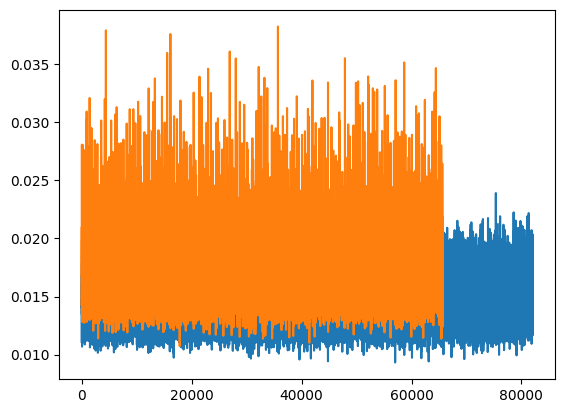

In [17]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

In [20]:
train_losses_file = open(configs["models_folder"] + "train_losses.txt",'w')
val_losses_file = open(configs["models_folder"] + "val_losses.txt","w")

for value in train_losses :
    train_losses_file.write(f"{value}\n")

for value in val_losses :
    val_losses_file.write(f"{value}\n")

train_losses_file.close()
val_losses_file.close()

In [23]:
best_model = StockLSTM()
best_model.load_state_dict(torch.load(configs["models_folder"] + "LSTM.pth.tar")['model'])

model.eval()

with torch.no_grad() :
    cur_test_loss = []
    for input,target in tqdm(test_loader) :

        close_price_input = input[:,4,:,None]
        close_price_target = target[:,4,:]
        close_price_input = close_price_input.to(device)
        close_price_target = close_price_target.to(device)

        if(close_price_input.shape[0] != configs["batch_size"]) :
            continue

        output = model(close_price_input)

        loss = loss_fn(output,close_price_target)

        cur_test_loss.append(loss.to(torch.device("cpu")).item())

    avarage_test_loss = np.mean(np.array(cur_test_loss))

print(avarage_test_loss)

  0%|          | 0/255 [00:00<?, ?it/s]

0.014298428242336812
